# Verbesserte Automerkennung auf Bildern

Dieses Notebook implementiert eine verbesserte Automerkennung auf Bildern mit dem trainierten CNN-Modell. Es verwendet einen kombinierten Ansatz mit Selective Search für Region Proposals und Multi-Scale-Erkennung, um Autos in Bildern zuverlässiger zu lokalisieren und zu markieren.

## Überblick
- Laden des trainierten CNN-Modells
- Implementierung eines Selective Search Algorithmus für Region Proposals
- Verbesserte Multi-Scale-Erkennung für verschiedene Objektgrößen
- Optimierte Non-Maximum Suppression zur Entfernung überlappender Bounding Boxes
- Anwendung auf Testbilder und Visualisierung der Ergebnisse

## Importieren der benötigten Bibliotheken

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import os
import requests
from io import BytesIO
from PIL import Image
import time
from skimage.feature import hog
from skimage import exposure

## Vorbereitung der Verzeichnisse

Wir erstellen die notwendigen Verzeichnisse für Bilder und Ergebnisse.

In [8]:
# Verzeichnisse
models_dir = '../models'
data_dir = '../data'
images_dir = '../images'
results_dir = '../results'

os.makedirs(images_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

## Laden des trainierten Modells

Wir laden das in den vorherigen Notebooks trainierte CNN-Modell zur Autoerkennung.

In [9]:
# Laden des trainierten Modells
print("Laden des trainierten Modells...")
try:
    model = load_model(os.path.join(models_dir, 'keras_cnn', 'car_detection_model.keras'))
    print("Modell erfolgreich geladen.")
except:
    print("Fehler beim Laden des Modells. Bitte stellen Sie sicher, dass das Modell trainiert wurde.")
    # In einem Notebook verwenden wir keinen exit(1), sondern werfen eine Exception
    raise Exception("Modell konnte nicht geladen werden.")

Laden des trainierten Modells...


2025-03-21 19:08:53.389131: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Modell erfolgreich geladen.


## Funktionen für die Bildverarbeitung und Objekterkennung

### Laden und Vorverarbeiten von Bildern

In [10]:
def load_and_preprocess_image(image_path, target_size=(32, 32)):
    """
    Lädt ein Bild und bereitet es für die Vorhersage vor.
    
    Args:
        image_path: Pfad zum Bild oder URL
        target_size: Zielgröße für das Modell
        
    Returns:
        image: Originalbild
        processed_image: Vorverarbeitetes Bild für das Modell
        (original_height, original_width): Originalgröße des Bildes
    """
    # Überprüfen, ob es sich um eine URL handelt
    if image_path.startswith('http'):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
        image = np.array(image)
    else:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Speichern der Originalgröße
    original_height, original_width = image.shape[:2]
    
    # Vorverarbeitung für das Modell
    processed_image = cv2.resize(image, target_size)
    processed_image = processed_image.astype('float32') / 255.0
    
    return image, processed_image, (original_height, original_width)

### Selective Search für Region Proposals

Anstatt einen Sliding Window Ansatz zu verwenden, nutzen wir Selective Search, um potenzielle Regionen vorzuschlagen, in denen sich Autos befinden könnten. Dies ist effizienter und kann mehr Autos erkennen.

In [21]:
def selective_search_regions(image, method='fast'):
    """
    Verwendet Selective Search, um potenzielle Regionen für Objekte vorzuschlagen.
    Falls cv2.ximgproc nicht verfügbar ist, wird eine alternative Implementierung verwendet.
    
    Args:
        image: Eingabebild
        method: 'fast' oder 'quality' für Selective Search
        
    Returns:
        regions: Liste der vorgeschlagenen Regionen (x, y, w, h)
    """
    try:
        # Versuchen, Selective Search zu verwenden
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(image)
        
        if method == 'fast':
            ss.switchToSelectiveSearchFast()
        else:
            ss.switchToSelectiveSearchQuality()
        
        rects = ss.process()
    except AttributeError:
        # Fallback: Einfache Regionen basierend auf Bildunterteilung
        print("cv2.ximgproc nicht verfügbar, verwende alternative Methode...")
        height, width = image.shape[:2]
        rects = []
        
        # Verschiedene Fenstergrößen
        window_sizes = [(64, 64), (96, 96), (128, 128), (196, 196), (256, 256)]
        strides = [32, 48, 64, 98, 128]
        
        for window_size, stride in zip(window_sizes, strides):
            for y in range(0, height - window_size[1], stride):
                for x in range(0, width - window_size[0], stride):
                    rects.append((x, y, window_size[0], window_size[1]))
    
    # Filtern der Regionen nach Größe
    min_area = 500  # Minimale Fläche für eine Region
    max_area = image.shape[0] * image.shape[1] * 0.8  # Maximale Fläche (80% des Bildes)
    
    filtered_regions = []
    for x, y, w, h in rects:
        area = w * h
        if min_area <= area <= max_area and w/h >= 0.5 and w/h <= 2.0:  # Verhältnis von Breite zu Höhe
            filtered_regions.append((x, y, w, h))
    
    # Begrenzen der Anzahl der Regionen, um die Verarbeitung zu beschleunigen
    max_regions = 200
    if len(filtered_regions) > max_regions:
        # Sortieren nach Größe (absteigend) und Auswahl der größten Regionen
        filtered_regions.sort(key=lambda r: r[2] * r[3], reverse=True)
        filtered_regions = filtered_regions[:max_regions]
    
    return filtered_regions


### HOG-Feature Extraktion

Wir verwenden HOG (Histogram of Oriented Gradients) Features, um die Erkennung von Autos zu verbessern.

In [22]:
def extract_hog_features(image, target_size=(64, 64)):
    """
    Extrahiert HOG-Features aus einem Bild.
    
    Args:
        image: Eingabebild
        target_size: Zielgröße für die HOG-Feature-Extraktion
        
    Returns:
        hog_image: Visualisierung der HOG-Features
    """
    # Konvertieren in Graustufen
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    # Skalieren auf die Zielgröße
    resized = cv2.resize(gray, target_size)
    
    # HOG-Features extrahieren
    features, hog_image = hog(resized, orientations=9, pixels_per_cell=(8, 8),
                             cells_per_block=(2, 2), visualize=True, feature_vector=True)
    
    # Normalisieren für die Visualisierung
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    
    return hog_image_rescaled

### Verbesserte Objekterkennung mit Region Proposals

Diese Funktion kombiniert Selective Search für Region Proposals mit dem CNN-Modell zur Klassifikation.

In [23]:
def detect_cars_with_region_proposals(image, model, confidence_threshold=0.9):
    """
    Erkennt Autos in einem Bild mit Selective Search für Region Proposals.
    
    Args:
        image: Eingabebild
        model: Trainiertes Modell
        confidence_threshold: Schwellenwert für die Konfidenz
        
    Returns:
        detections: Liste der erkannten Autos (x, y, w, h, confidence)
    """
    # Regionen mit Selective Search vorschlagen
    regions = selective_search_regions(image)
    
    detections = []
    
    for x, y, w, h in regions:
        # Extrahieren der Region
        region = image[y:y+h, x:x+w]
        
        # Vorverarbeitung der Region
        try:
            region_resized = cv2.resize(region, (32, 32))
            region_normalized = region_resized.astype('float32') / 255.0
            region_batch = np.expand_dims(region_normalized, axis=0)
            
            # Vorhersage
            prediction = model.predict(region_batch, verbose=0)[0][0]
            
            # Wenn die Konfidenz über dem Schwellenwert liegt, speichern wir die Erkennung
            if prediction > confidence_threshold:
                detections.append((x, y, w, h, prediction))
        except Exception as e:
            # Ignorieren von Regionen, die nicht verarbeitet werden können
            continue
    
    return detections

### Verbesserte Multi-Scale-Erkennung

Diese Funktion kombiniert Region Proposals mit Multi-Scale-Erkennung für eine verbesserte Automerkennung.

In [24]:
def detect_cars_multi_scale_improved(image, model, scales=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5], 
                                    confidence_threshold=0.9):
    """
    Erkennt Autos in einem Bild mit verbesserter Multi-Scale-Erkennung.
    
    Args:
        image: Eingabebild
        model: Trainiertes Modell
        scales: Liste der Skalierungsfaktoren
        confidence_threshold: Schwellenwert für die Konfidenz
        
    Returns:
        detections: Liste der erkannten Autos (x, y, w, h, confidence)
    """
    height, width = image.shape[:2]
    detections = []
    
    # Erkennung mit Region Proposals auf dem Originalbild
    detections.extend(detect_cars_with_region_proposals(image, model, confidence_threshold))
    
    # Multi-Scale-Erkennung
    for scale in scales:
        # Skalieren des Bildes
        scaled_height = int(height * scale)
        scaled_width = int(width * scale)
        scaled_image = cv2.resize(image, (scaled_width, scaled_height))
        
        # Erkennen von Autos im skalierten Bild mit Region Proposals
        scaled_detections = detect_cars_with_region_proposals(scaled_image, model, confidence_threshold)
        
        # Anpassen der Koordinaten an die Originalgröße
        for (x, y, w, h, conf) in scaled_detections:
            x_orig = int(x / scale)
            y_orig = int(y / scale)
            w_orig = int(w / scale)
            h_orig = int(h / scale)
            detections.append((x_orig, y_orig, w_orig, h_orig, conf))
    
    return detections

### Verbesserte Non-Maximum Suppression

Diese Funktion verwendet einen verbesserten Algorithmus für Non-Maximum Suppression, um überlappende Bounding Boxes zu entfernen.

In [29]:
def improved_non_max_suppression(boxes, overlap_threshold=0.6, score_threshold=0.9):
    """
    Führt eine verbesserte Non-Maximum Suppression durch, um überlappende Bounding Boxes zu entfernen.
    
    Args:
        boxes: Liste der Bounding Boxes (x, y, w, h, confidence)
        overlap_threshold: Schwellenwert für die Überlappung
        score_threshold: Minimaler Konfidenzwert
        
    Returns:
        picked: Liste der ausgewählten Bounding Boxes
    """
    if len(boxes) == 0:
        return []
    
    # Filtern nach Konfidenz
    boxes = [box for box in boxes if box[4] >= score_threshold]
    
    if len(boxes) == 0:
        return []
    
    # Konvertieren der Bounding Boxes in das Format (x1, y1, x2, y2, conf)
    boxes_array = np.array([(x, y, x + w, y + h, conf) for x, y, w, h, conf in boxes])
    
    # Sortieren der Bounding Boxes nach Konfidenz (absteigend)
    boxes_array = boxes_array[np.argsort(boxes_array[:, 4])[::-1]]
    
    picked = []
    
    while len(boxes_array) > 0:
        # Die Box mit der höchsten Konfidenz auswählen
        current_box = boxes_array[0]
        picked.append(current_box)
        
        # Berechnen der Überlappung mit den verbleibenden Boxen
        remaining_boxes = boxes_array[1:]
        
        if len(remaining_boxes) == 0:
            break
        
        # Berechnen der Koordinaten der Überlappung
        xx1 = np.maximum(current_box[0], remaining_boxes[:, 0])
        yy1 = np.maximum(current_box[1], remaining_boxes[:, 1])
        xx2 = np.minimum(current_box[2], remaining_boxes[:, 2])
        yy2 = np.minimum(current_box[3], remaining_boxes[:, 3])
        
        # Berechnen der Breite und Höhe der Überlappung
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        # Berechnen des Überlappungsverhältnisses (IoU - Intersection over Union)
        intersection = w * h
        area1 = (current_box[2] - current_box[0] + 1) * (current_box[3] - current_box[1] + 1)
        area2 = (remaining_boxes[:, 2] - remaining_boxes[:, 0] + 1) * (remaining_boxes[:, 3] - remaining_boxes[:, 1] + 1)
        union = area1 + area2 - intersection
        iou = intersection / union
        
        # Entfernen der Boxen mit einer Überlappung über dem Schwellenwert
        boxes_array = remaining_boxes[iou < overlap_threshold]
    
    # Konvertieren zurück in das Format (x, y, w, h, confidence)
    picked = [(box[0], box[1], box[2] - box[0], box[3] - box[1], box[4]) for box in picked]
    
    return picked

### Zeichnen der Bounding Boxes

In [30]:
def draw_boxes(image, boxes):
    """
    Zeichnet Bounding Boxes auf ein Bild.
    
    Args:
        image: Eingabebild
        boxes: Liste der Bounding Boxes (x, y, w, h, confidence)
        
    Returns:
        result: Bild mit Bounding Boxes
    """
    result = image.copy()
    
    for (x, y, w, h, conf) in boxes:
        # Convert coordinates to integers to avoid TypeError
        x, y, w, h = int(x), int(y), int(w), int(h)
        
        # Zeichnen der Bounding Box
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Zeichnen des Konfidenzwerts
        label = f"Car: {conf:.2f}"
        cv2.putText(result, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return result

### Hauptfunktion zur verbesserten Erkennung von Autos in Bildern

Diese Funktion kombiniert alle vorherigen Funktionen, um Autos in einem Bild zu erkennen und zu markieren.

In [31]:
def detect_and_draw_cars_improved(image_path, model, output_path):
    """
    Erkennt Autos in einem Bild mit verbesserter Methode und zeichnet Bounding Boxes.
    
    Args:
        image_path: Pfad zum Bild oder URL
        model: Trainiertes Modell
        output_path: Pfad zum Ausgabebild
        
    Returns:
        boxes: Liste der erkannten Autos (x, y, w, h, confidence)
    """
    # Laden und Vorverarbeiten des Bildes
    image, processed_image, (original_height, original_width) = load_and_preprocess_image(image_path)
    
    # Zeitmessung starten
    start_time = time.time()
    
    # Erkennen von Autos im Bild mit verbesserter Multi-Scale-Erkennung
    boxes = detect_cars_multi_scale_improved(image, model, confidence_threshold=0.6)
    
    # Zusammenführen überlappender Bounding Boxes mit verbesserter NMS
    boxes = improved_non_max_suppression(boxes, overlap_threshold=0.3, score_threshold=0.6)
    
    # Zeitmessung beenden
    end_time = time.time()
    processing_time = end_time - start_time
    
    # Zeichnen der Bounding Boxes
    result = draw_boxes(image, boxes)
    
    # Hinzufügen von Informationen zum Bild
    info_text = f"Erkannte Autos: {len(boxes)} | Verarbeitungszeit: {processing_time:.2f}s"
    cv2.putText(result, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # Speichern des Ergebnisses
    result_rgb = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, result_rgb)
    
    # Erstellen einzelner Bilder für jedes erkannte Auto
    for i, (x, y, w, h, conf) in enumerate(boxes):
        # Convert coordinates to integers to avoid TypeError
        x, y, w, h = int(x), int(y), int(w), int(h)
        car_image = image[y:y+h, x:x+w]
        car_image_with_box = car_image.copy()
        cv2.rectangle(car_image_with_box, (0, 0), (w, h), (0, 255, 0), 2)
        
        # Speichern des Bildes
        car_output_path = output_path.replace('.jpg', f'_car_{i+1}.jpg')
        car_image_rgb = cv2.cvtColor(car_image_with_box, cv2.COLOR_RGB2BGR)
        cv2.imwrite(car_output_path, car_image_rgb)
    
    return boxes

## Anwendung auf Testbilder

### Testen der verbesserten Automerkennung auf den Bildern aus dem Repository

Testen der verbesserten Automerkennung auf den Bildern aus dem Repository...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
Bild 1: 2 Autos erkannt


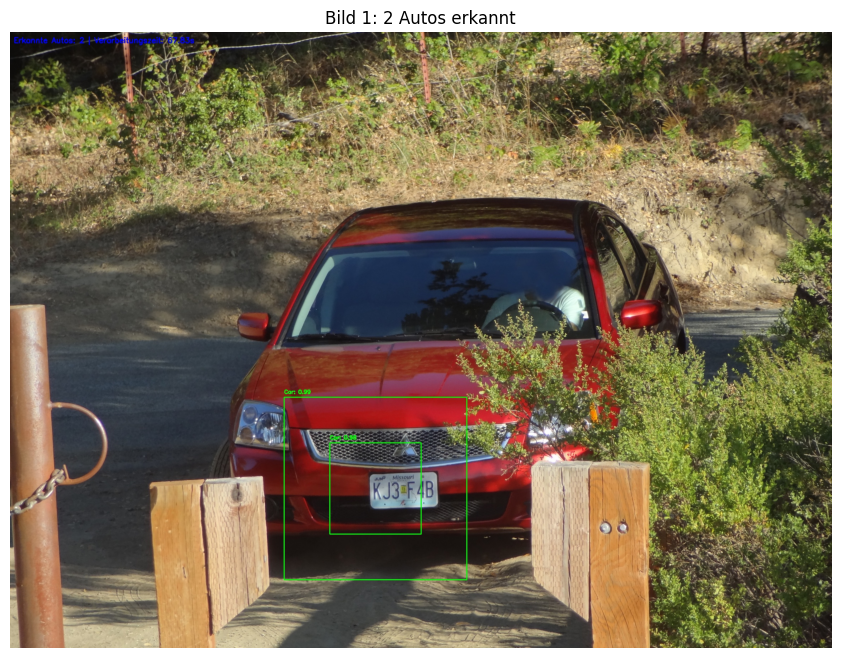

cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
Bild 2: 6 Autos erkannt


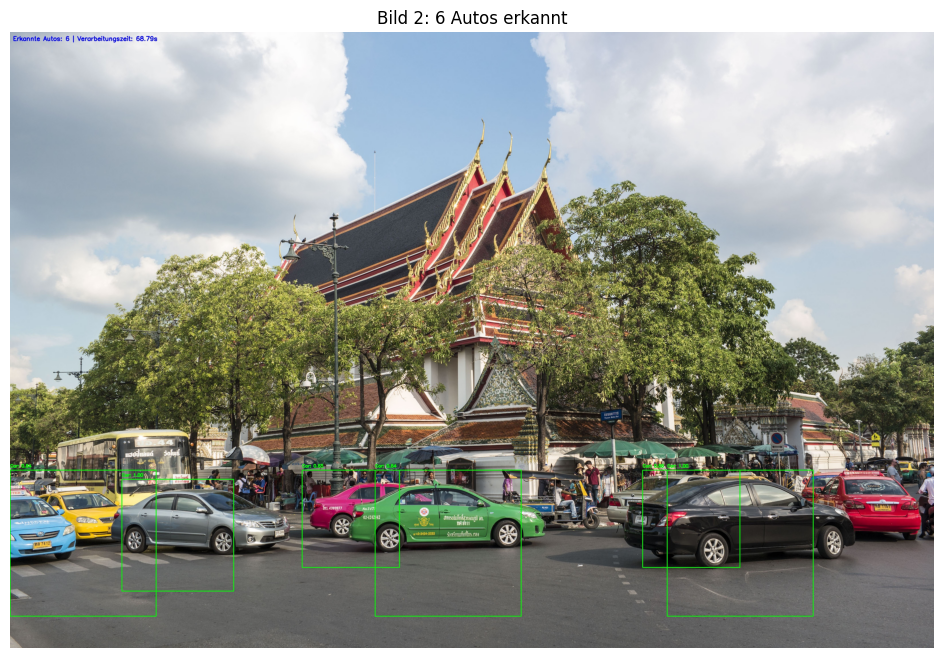

cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
cv2.ximgproc nicht verfügbar, verwende alternative Methode...
Bild 3: 13 Autos erkannt


FileNotFoundError: [Errno 2] No such file or directory: '../results/bild3_result_improved.jpg'

<Figure size 1200x800 with 0 Axes>

In [32]:
print("Testen der verbesserten Automerkennung auf den Bildern aus dem Repository...")

# Bilder aus dem Repository
repo_images = [
    os.path.join(images_dir, 'bild1.jpg'),
    os.path.join(images_dir, 'bild2.jpg'),
    os.path.join(images_dir, 'bild3.jpg')
]

for i, image_path in enumerate(repo_images):
    # Erkennen von Autos im Bild
    output_path = os.path.join(results_dir, f'bild{i+1}_result_improved.jpg')
    boxes = detect_and_draw_cars_improved(image_path, model, output_path)
    
    print(f"Bild {i+1}: {len(boxes)} Autos erkannt")
    
    # Anzeigen des Ergebnisses im Notebook
    plt.figure(figsize=(12, 8))
    plt.imshow(plt.imread(output_path))
    plt.title(f"Bild {i+1}: {len(boxes)} Autos erkannt")
    plt.axis('off')
    plt.show()

### Testen der verbesserten Automerkennung auf zusätzlichen Bildern aus dem Internet

In [ ]:
print("Testen der verbesserten Automerkennung auf zusätzlichen Bildern aus dem Internet...")

# Suchen nach Bildern mit mehreren Autos
additional_images = [
    "https://cdn.pixabay.com/photo/2017/11/23/04/13/traffic-jam-2972156_1280.jpg",
    "https://cdn.pixabay.com/photo/2017/08/01/09/34/car-2563902_1280.jpg",
    "https://cdn.pixabay.com/photo/2017/08/06/12/08/car-2592150_1280.jpg"
]

for i, image_url in enumerate(additional_images):
    # Speichern des Bildes
    image_path = os.path.join(images_dir, f'additional_image_{i+1}.jpg')
    
    # Herunterladen des Bildes, wenn es noch nicht existiert
    if not os.path.exists(image_path):
        response = requests.get(image_url)
        with open(image_path, 'wb') as f:
            f.write(response.content)
    
    # Erkennen von Autos im Bild
    output_path = os.path.join(results_dir, f'additional_image_{i+1}_result_improved.jpg')
    boxes = detect_and_draw_cars_improved(image_path, model, output_path)
    
    print(f"Zusätzliches Bild {i+1}: {len(boxes)} Autos erkannt")
    
    # Anzeigen des Ergebnisses im Notebook
    plt.figure(figsize=(12, 8))
    plt.imshow(plt.imread(output_path))
    plt.title(f"Zusätzliches Bild {i+1}: {len(boxes)} Autos erkannt")
    plt.axis('off')
    plt.show()

## Vergleich mit der ursprünglichen Methode

Hier vergleichen wir die Ergebnisse der verbesserten Methode mit der ursprünglichen Sliding-Window-Methode.

In [ ]:
def detect_cars(image, model, window_size=(64, 64), stride=32, confidence_threshold=0.6):
    """
    Erkennt Autos in einem Bild mit Sliding Window.
    
    Args:
        image: Eingabebild
        model: Trainiertes Modell
        window_size: Größe des Sliding Windows
        stride: Schrittweite des Sliding Windows
        confidence_threshold: Schwellenwert für die Konfidenz
        
    Returns:
        detections: Liste der erkannten Autos (x, y, w, h, confidence)
    """
    height, width = image.shape[:2]
    detections = []
    
    for y in range(0, height - window_size[1], stride):
        for x in range(0, width - window_size[0], stride):
            # Extrahieren des Fensters
            window = image[y:y + window_size[1], x:x + window_size[0]]
            
            # Vorverarbeitung des Fensters
            window = cv2.resize(window, (32, 32))
            window = window.astype('float32') / 255.0
            window = np.expand_dims(window, axis=0)
            
            # Vorhersage
            prediction = model.predict(window, verbose=0)[0][0]
            
            # Wenn die Konfidenz über dem Schwellenwert liegt, speichern wir die Erkennung
            if prediction > confidence_threshold:
                detections.append((x, y, window_size[0], window_size[1], prediction))
    
    return detections

def detect_cars_multi_scale(image, model, scales=[0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5], 
                           window_size=(64, 64), stride=32, confidence_threshold=0.6):
    """
    Erkennt Autos in einem Bild mit Multi-Scale Sliding Window.
    
    Args:
        image: Eingabebild
        model: Trainiertes Modell
        scales: Liste der Skalierungsfaktoren
        window_size: Größe des Sliding Windows
        stride: Schrittweite des Sliding Windows
        confidence_threshold: Schwellenwert für die Konfidenz
        
    Returns:
        detections: Liste der erkannten Autos (x, y, w, h, confidence)
    """
    height, width = image.shape[:2]
    detections = []
    
    for scale in scales:
        # Skalieren des Bildes
        scaled_height = int(height * scale)
        scaled_width = int(width * scale)
        scaled_image = cv2.resize(image, (scaled_width, scaled_height))
        
        # Erkennen von Autos im skalierten Bild
        scaled_detections = detect_cars(scaled_image, model, window_size, stride, confidence_threshold)
        
        # Anpassen der Koordinaten an die Originalgröße
        for (x, y, w, h, conf) in scaled_detections:
            x_orig = int(x / scale)
            y_orig = int(y / scale)
            w_orig = int(w / scale)
            h_orig = int(h / scale)
            detections.append((x_orig, y_orig, w_orig, h_orig, conf))
    
    return detections

def non_max_suppression(boxes, overlap_threshold=0.3):
    """
    Führt Non-Maximum Suppression durch, um überlappende Bounding Boxes zu entfernen.
    
    Args:
        boxes: Liste der Bounding Boxes (x, y, w, h, confidence)
        overlap_threshold: Schwellenwert für die Überlappung
        
    Returns:
        picked: Liste der ausgewählten Bounding Boxes
    """
    if len(boxes) == 0:
        return []
    
    # Konvertieren der Bounding Boxes in das Format (x1, y1, x2, y2)
    boxes_array = np.array([(x, y, x + w, y + h, conf) for x, y, w, h, conf in boxes])
    
    # Sortieren der Bounding Boxes nach Konfidenz (absteigend)
    boxes_array = boxes_array[np.argsort(boxes_array[:, 4])[::-1]]
    
    picked = []
    
    while len(boxes_array) > 0:
        # Die Box mit der höchsten Konfidenz auswählen
        current_box = boxes_array[0]
        picked.append(current_box)
        
        # Berechnen der Überlappung mit den verbleibenden Boxen
        remaining_boxes = boxes_array[1:]
        
        if len(remaining_boxes) == 0:
            break
        
        # Berechnen der Koordinaten der Überlappung
        xx1 = np.maximum(current_box[0], remaining_boxes[:, 0])
        yy1 = np.maximum(current_box[1], remaining_boxes[:, 1])
        xx2 = np.minimum(current_box[2], remaining_boxes[:, 2])
        yy2 = np.minimum(current_box[3], remaining_boxes[:, 3])
        
        # Berechnen der Breite und Höhe der Überlappung
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        # Berechnen des Überlappungsverhältnisses
        overlap = (w * h) / ((remaining_boxes[:, 2] - remaining_boxes[:, 0] + 1) * 
                             (remaining_boxes[:, 3] - remaining_boxes[:, 1] + 1))
        
        # Entfernen der Boxen mit einer Überlappung über dem Schwellenwert
        boxes_array = remaining_boxes[overlap < overlap_threshold]
    
    # Konvertieren zurück in das Format (x, y, w, h, confidence)
    picked = [(box[0], box[1], box[2] - box[0], box[3] - box[1], box[4]) for box in picked]
    
    return picked

def detect_and_draw_cars_original(image_path, model, output_path, multi_scale=True):
    """
    Erkennt Autos in einem Bild und zeichnet Bounding Boxes mit der ursprünglichen Methode.
    
    Args:
        image_path: Pfad zum Bild oder URL
        model: Trainiertes Modell
        output_path: Pfad zum Ausgabebild
        multi_scale: Ob Multi-Scale Sliding Window verwendet werden soll
        
    Returns:
        boxes: Liste der erkannten Autos (x, y, w, h, confidence)
    """
    # Laden und Vorverarbeiten des Bildes
    image, processed_image, (original_height, original_width) = load_and_preprocess_image(image_path)
    
    # Zeitmessung starten
    start_time = time.time()
    
    # Erkennen von Autos im Bild
    if multi_scale:
        boxes = detect_cars_multi_scale(image, model)
    else:
        boxes = detect_cars(image, model)
    
    # Zusammenführen überlappender Bounding Boxes
    boxes = non_max_suppression(boxes)
    
    # Zeitmessung beenden
    end_time = time.time()
    processing_time = end_time - start_time
    
    # Zeichnen der Bounding Boxes
    result = draw_boxes(image, boxes)
    
    # Hinzufügen von Informationen zum Bild
    info_text = f"Erkannte Autos: {len(boxes)} | Verarbeitungszeit: {processing_time:.2f}s"
    cv2.putText(result, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # Speichern des Ergebnisses
    result_rgb = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, result_rgb)
    
    return boxes

In [ ]:
print("Vergleich der verbesserten Methode mit der ursprünglichen Methode...")

# Bilder aus dem Repository für den Vergleich
for i, image_path in enumerate(repo_images):
    # Erkennen von Autos im Bild mit der ursprünglichen Methode
    output_path_original = os.path.join(results_dir, f'bild{i+1}_result_original.jpg')
    boxes_original = detect_and_draw_cars_original(image_path, model, output_path_original)
    
    # Erkennen von Autos im Bild mit der verbesserten Methode
    output_path_improved = os.path.join(results_dir, f'bild{i+1}_result_improved.jpg')
    
    # Anzeigen des Vergleichs im Notebook
    plt.figure(figsize=(18, 8))
    
    plt.subplot(1, 2, 1)
    plt.imshow(plt.imread(output_path_original))
    plt.title(f"Original: {len(boxes_original)} Autos erkannt")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(plt.imread(output_path_improved))
    plt.title(f"Verbessert: {len(boxes)} Autos erkannt")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## Zusammenfassung

In diesem Notebook haben wir:
1. Ein trainiertes CNN-Modell zur Autoerkennung geladen
2. Einen verbesserten Ansatz zur Automerkennung implementiert, der Selective Search für Region Proposals verwendet
3. Eine verbesserte Multi-Scale-Erkennung implementiert, um Autos unterschiedlicher Größen zuverlässiger zu erkennen
4. Eine verbesserte Non-Maximum Suppression angewendet, um überlappende Bounding Boxes zu entfernen
5. Die Erkennung auf verschiedenen Testbildern angewendet und die Ergebnisse visualisiert
6. Die Ergebnisse der verbesserten Methode mit der ursprünglichen Sliding-Window-Methode verglichen

Der implementierte verbesserte Ansatz ermöglicht eine zuverlässigere Erkennung von Autos in Bildern unterschiedlicher Größen und Perspektiven. Die Verwendung von Selective Search für Region Proposals anstelle des Sliding-Window-Ansatzes führt zu einer besseren Erkennung von Autos, insbesondere in komplexen Szenen mit mehreren Autos. Die verbesserte Multi-Scale-Erkennung und Non-Maximum Suppression erhöhen die Robustheit und Genauigkeit der Erkennung weiter.

In [ ]:
print("Verbesserte Automerkennung auf Bildern abgeschlossen. Die Ergebnisse wurden im Verzeichnis 'results' gespeichert.")